# Aquisição e Manipulação de Dados

## Modelagem do Futebol Brasileiro

### Autores: Hanna Rodrigues e Igor Michels

_________________________

### Import's

In [1]:
from models import *
from functions import *
from scipy.optimize import minimize
from scipy.stats import poisson
from datetime import timedelta
from random import choice
from glob import glob
import time as tm
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy.random as rd
import seaborn as sns

sns.set_style("white")

_________________________

### Objetivos do negócio:

O projeto objetiva a criação de um modelo de predição de resultados gerais dos jogos do futebol brasileiro em vitória, derrota ou empate, bem como a inferência do campeão brasileiro utilizando um modelo que será implementado utilizando dados disponíveis sobre jogos da Série A do Brasileirão que podem ser encontrados no site da CBF e em outros sites esportivos.


### Avaliação da situação atual:

Atualmente casas de apostas possuem bons modelos preditivos para a elaboração das odds, enquanto modelos mais simples são utilizados, seja em pesquisa ou seja com objetivos didáticos. Além disso, existem muitos dados disponíveis acerca do tema, uma vez que o futebol é o esporte mais popular do planeta, ou seja, pode-se encontrar os mais variados dados facilmente.


### Objetivo da mineração de dados:

A coleta de dados objetiva, inicialmente, os dados mais gerais de uma partida:

 + mandante;
 + visitante;
 + placar e;
 + data.

Tais dados podem ser obtidos diretamente do site da CBF, como realizado [nesse projeto](https://github.com/IgorMichels/Brazilian_Soccer).


### Plano do projeto:
    
 + Coletar dados do futebol brasileiro via scraping
     + ver [esse repositório](https://github.com/IgorMichels/Brazilian_Soccer/tree/main/Scrape_and_some_views/All%20data/Serie%20A)
 + Explorar e verificar a qualidade dos dados coletados
 + Selecionar, limpar e reformatar os dados que alimentarão o modelo
 + Construir e treinar o modelo de previsão de partidas
     + elaborar modelo estimando forças para cada clube, utilizando os jogos anteriores para realizar o treinamento, com jogos mais recentes tendo peso maior
 + Validar e analisar as previsões do modelo
     + para essa etapa a ideia é utilizar os dados do começo dos campeonatos de 2019 e 2020 (10 primeiras rodadas ou primeiro turno inteiro) para realizar o treinamento do modelo e utilizar os parâmetros obtidos para validar o modelo nesses anos
 + Inferir o campeão brasileiro com o modelo implementado
 + Revisar e fazer o deploy do projeto


# Entendimento dos Dados

### Coleta Inicial dos Dados

A coleta inicial dos dados já foi realizada em um projeto anterior, conforme seção acima. Dessa forma, realizamos apenas o download dos dados para esse projeto, considerando todos os jogos de todas as competições da CBF no período de 2013 a 2020.

### Descrição dos Dados

Os dados coletados estão no formato ```csv```, com a súmula crua e completa de cada partida, conforme pode ser visto abaixo.

In [2]:
game = 'Data/Serie A/2020/Game 001.csv' # Flamengo e Atlético-MG pela primeira rodada de 2020
lines_2_print = 25
lines = 0
with open(game) as file:
    reader = csv.reader(file, delimiter = ',')
    for row in reader:
        print(row)
        
        lines += 1
        if lines == lines_2_print:
            break

['Campeonato:', 'Campeonato Brasileiro - Série A / 2020', 'Rodada:', '1', '', '']
['Jogo:', 'Flamengo / RJ X Atlético / MG', '', '', '', '']
['Data:', '09/08/2020', 'Horário:', '16:00', 'Estádio:', 'Jornalista Mário Filho / Rio de Janeiro']
['Arbitragem', '']
['Arbitro:', 'Raphael Claus (FIFA / SP)']
['Arbitro Assistente 1:', 'Daniel Paulo Ziolli (AB / SP)']
['Arbitro Assistente 2:', 'Anderson José de Moraes Coelho (AB / SP)']
['Quarto Arbitro:', 'Rafael Martins de Sá (CD / RJ)']
['Analista de Campo:', 'Edilson Soares da Silva (CBF / RJ)']
['VAR:', 'Thiago Duarte Peixoto (AB / SP)']
['AVAR1:', 'Vinicius Furlan (AB / SP)']
['AVAR2:', 'Enderson Emanoel Turbiani da Silva (AB / SP)']
['Observador de VAR:', 'Nilson de Souza Monção (CBF / RJ)']
['Quality manager:', 'Mikael Silva de Araujo (CBF / RJ)']
['Cronologia', '', '', '', '', '', '', '']
['1o Tempo', '2o Tempo', '', '', '', '', '', '']
['Entrada do mandante:', '15:50', 'Atraso:', 'Não Houve', 'Entrada do mandante:', '16:57', 'Atraso:',

Os dados da súmula foram retirados de um ```PDF``` e convertidos para ```csv``` por meio da biblioteca ```tabula```.

### Exploração dos Dados

Essa etapa pensamos em adiar um pouco para realizar após a limpeza dos dados, uma vez que os mesmos precisam ser tratados. Mas uma análise rápida dos dados nos mostra que todos os dados de nosso interesse se encontram no ínicio da súmula, antes da relação de jogadores.

Podemos ver que até esse ponto já pudemos coletar informações como os clubes que estão se enfrentando, a data da partida e o resultado final do jogo:

In [3]:
with open(game) as file:
    reader = csv.reader(file, delimiter = ',')
    for row in reader:
        if 'Relação de Jogadores' in row:
            break
            
        print(row)

['Campeonato:', 'Campeonato Brasileiro - Série A / 2020', 'Rodada:', '1', '', '']
['Jogo:', 'Flamengo / RJ X Atlético / MG', '', '', '', '']
['Data:', '09/08/2020', 'Horário:', '16:00', 'Estádio:', 'Jornalista Mário Filho / Rio de Janeiro']
['Arbitragem', '']
['Arbitro:', 'Raphael Claus (FIFA / SP)']
['Arbitro Assistente 1:', 'Daniel Paulo Ziolli (AB / SP)']
['Arbitro Assistente 2:', 'Anderson José de Moraes Coelho (AB / SP)']
['Quarto Arbitro:', 'Rafael Martins de Sá (CD / RJ)']
['Analista de Campo:', 'Edilson Soares da Silva (CBF / RJ)']
['VAR:', 'Thiago Duarte Peixoto (AB / SP)']
['AVAR1:', 'Vinicius Furlan (AB / SP)']
['AVAR2:', 'Enderson Emanoel Turbiani da Silva (AB / SP)']
['Observador de VAR:', 'Nilson de Souza Monção (CBF / RJ)']
['Quality manager:', 'Mikael Silva de Araujo (CBF / RJ)']
['Cronologia', '', '', '', '', '', '', '']
['1o Tempo', '2o Tempo', '', '', '', '', '', '']
['Entrada do mandante:', '15:50', 'Atraso:', 'Não Houve', 'Entrada do mandante:', '16:57', 'Atraso:',

### Verificando a Qualidade dos Dados

Essa etapa acaba sendo rápida nesse caso, pois os dados foram obtidos das súmulas das partidas que estão no site da CBF, ou seja, são dados oficiais de cada jogo e que se encontram no site oficial do organizador do evento.

# Preparação dos Dados

### Seleção e Limpeza dos Dados

Conforme citado anteriormente, tomamos os dados de todos os jogos de todas as competições da CBF de 2013 a 2020. Como estamos interessados na modelagem da primeira divisão, nessa etapa iremos fazer a seleção dos jogos entre os clubes que já estiveram na Série A, em qualquer que seja a competição.

Pensando em otimizar o processo, decidimos unificar a etapa de seleção e limpeza dos dados. Dessa forma, enquanto passamos por cada jogo, já iremos ver se os clubes que estão se enfrentando estiveram na Série A em algum desses anos. Se sim, então a gente guarda os dados dessa partida, caso contrário essa partida não será de grande valia para nossa análise, então descartamos a mesma.

**OBS:** A ideia de pegar todas as competições se dá pelo fato de que, na Série A, ocorre, a cada ano, a renovação de 20% dos clubes (4 são rebaixados e 4 são promovidos), então para termos dados prévios desses clubes que foram promovidos uma opção é a de utilizar os jogos de divisões inferiores.

In [4]:
def cleaning_data(competitions1 = None, competitions2 = None, output_file = None):
    if competitions1 == None and competitions2 == None:
        competitions = sorted(glob('Data/S*')) + glob('Data/C*') # garantir que a Série A seja a primeira da lista
        competitions1 = [competitions[0]] # only Serie A
        competitions2 = competitions[1:]
    
    if output_file == None:
        output_file = 'Clean Data/data.csv'
    
    save = []
    clubs = []
    for competition in competitions1:
        years = sorted(glob(competition + '/*'))
        for year in years:
            games = sorted(glob(year + '/Game *'))
            for game in games:
                save.append([game[5:game.find('/', 5)]])
                try:
                    teams = find_teams(game)
                    date = find_date(game)
                    score = find_score(game)
                    for team in teams:
                        save[-1].append(team)
                        if team not in clubs:
                            clubs.append(team)

                    save[-1].append(score)
                    for info in date:
                        save[-1].append(info)

                except UnicodeDecodeError:
                    print('UnicodeDecodeError at ' + game)
                    save.pop()

    if competitions2 != None:
        for competition in competitions2:
            years = sorted(glob(competition + '/*'))
            for year in years:
                games = sorted(glob(year + '/Game *'))
                for game in games:
                    save.append([game[5:game.find('/', 5)]])
                    try:
                        teams = find_teams(game)
                        if len(teams) == 2 and teams[0] in clubs and teams[1] in clubs:
                            date = find_date(game)
                            score = find_score(game)
                            for team in teams:
                                save[-1].append(team)

                            save[-1].append(score)
                            for info in date:
                                save[-1].append(info)
                        else:
                            save.pop()

                    except UnicodeDecodeError:
                        # CdB - 2016 - game 122 is Fluminense vs Ypiranga
                        print('UnicodeDecodeError at ' + game)
                        save.pop()

    with open(output_file, 'w') as file:
        writer = csv.writer(file)
        writer.writerow(['Competition', 'Team 1', 'Team 2', 'Result', 'Round', 'Year', 'Date'])
        for game in save:
            if len(game[3]) > 3 and game[3][2] == 'x':
                writer.writerow(game[:7])
            
def calculate_missing_date(df, interval, column):
    beg, end = interval
    years = {'all' : [0 , 0]}
    for i in range(beg, end):
        years['all'][1] += 1
        if type(df.loc[i, column]) != str:
            # não temos a data
            years['all'][0] += 1
            if df.loc[i, 'Year'] not in years:
                years[df.loc[i, 'Year']] = [1, 1]
            else:
                years[df.loc[i, 'Year']][0] += 1
                years[df.loc[i, 'Year']][1] += 1
        else:
            # temos a data
            if df.loc[i, 'Year'] not in years:
                years[df.loc[i, 'Year']] = [0, 1]
            else:
                years[df.loc[i, 'Year']][1] += 1

    return years, years['all'][0]/years['all'][1]

if 'Clean Data/data.csv' not in glob('Clean Data/*'): 
    cleaning_data()

Tendo realizado essa etapa, obtemos um arquivo ```csv``` contendo apenas os dados dos jogos de nosso interesse e, agora sim, vamos a Exploração dos Dados.

**OBS:** a última linha está comentanda pois já realizamos esse processo uma vez, então não é necessário fazer isso novamente cada vez que abrimos o notebook.

### Tratamento, transformação e formatação dos Dados

Essas 4 etapas acontecerão simultaneamente, isso é, vamos realizar o tratamento dos dados ao passo que transformamos e formatamos os mesmos. Dessa forma, uma ideia inicial para essa etapa é visualizar nossos dados em um ```dataframe```, possibilitando uma visão geral dos mesmos.

In [5]:
df = pd.read_csv('Clean Data/data.csv')
df

,Competition,Team 1,Team 2,Result,Round,Year,Date
0,Serie A,Vasco da Gama / RJ,Portuguesa / SP,1 x 0,1,2013,25/05/2013
1,Serie A,Fluminense / RJ,Athlético / PR,2 x 1,1,2013,NaN
2,Serie A,Corinthians / SP,Botafogo / RJ,1 x 1,1,2013,NaN
3,Serie A,Vitória / BA,Internacional / RS,2 x 2,1,2013,NaN
4,Serie A,Grêmio / RS,Náutico / PE,2 x 0,1,2013,NaN
...,...,...,...,...,...,...,...
4446,Copa do Brasil,Bahia / BA,Atlético / MG,2 x 1,11,2021,04/08/2021
4447,Copa do Brasil,Athlético / PR,Santos / SP,1 x 0,11,2021,25/08/2021
4448,Copa do Brasil,Grêmio / RS,Flamengo / RJ,0 x 4,11,2021,25/08/2021
4449,Copa do Brasil,São Paulo / SP,Fortaleza / CE,2 x 2,12,2021,25/08/2021


Podemos ver que existem muitos dados faltantes na coluna Date. Isso nos dá duas opções:

+ excluir essa coluna e considerar as colunas Year e Round como lapso temporal (isso implicaria na exclusão das partidas da Copa do Brasil, que, como veremos abaixo, são 380 ao todo);
+ ou usar os valores que temos para inferir os valores faltantes (os jogos de uma mesma rodada tendem a ser no mesmo intervalo de 2 a 3 dias, o que facilitaria o processo).

Vale ressaltar que os jogos, mesmo dentro de uma mesma rodada, não estão em ordem cronológica.

In [6]:
count = 0
for i in range(len(df)):
    if df.loc[i, 'Competition'] == 'Copa do Brasil':
        count += 1
        
count

380

Nossa opção se dará pelo segundo caminho, ou seja, buscar inferir os valores faltantes por meio dos valores existentes. Para isso, vamos usar a interpolação pelos valores próximos. O código nas linhas 7 a 15 são para corrigir um problema de data, onde alguns valores estava sendo considerados no formato mm/dd/aaaa.

In [7]:
df['Date_by_Nearest'] = matplotlib.dates.date2num(pd.to_datetime(df['Date']))
df['Date_by_Nearest'].interpolate(method = 'nearest', inplace = True)
df['Date_by_Nearest'] = df['Date_by_Nearest'].apply(np.round)
df['Date_by_Nearest'] = matplotlib.dates.num2date(df['Date_by_Nearest'])
df['Date_by_Nearest'] = df['Date_by_Nearest'].dt.strftime('%d/%m/%Y')

nearest_date = list(df['Date_by_Nearest'])
for i in range(len(nearest_date)):
    if int(nearest_date[i][3:5]) > 12:
        nearest_date[i] = nearest_date[i][3:5] + '/' + nearest_date[i][:2] + '/' + nearest_date[i][-4:]
    else:
        if int(nearest_date[i][:2]) < 12:
            nearest_date[i] = nearest_date[i][3:5] + '/' + nearest_date[i][:2] + '/' + nearest_date[i][-4:]
            
df['Date_by_Nearest'] = nearest_date
df

,Competition,Team 1,Team 2,Result,Round,Year,Date,Date_by_Nearest
0,Serie A,Vasco da Gama / RJ,Portuguesa / SP,1 x 0,1,2013,25/05/2013,25/05/2013
1,Serie A,Fluminense / RJ,Athlético / PR,2 x 1,1,2013,NaN,25/05/2013
2,Serie A,Corinthians / SP,Botafogo / RJ,1 x 1,1,2013,NaN,25/05/2013
3,Serie A,Vitória / BA,Internacional / RS,2 x 2,1,2013,NaN,25/05/2013
4,Serie A,Grêmio / RS,Náutico / PE,2 x 0,1,2013,NaN,25/05/2013
...,...,...,...,...,...,...,...,...
4446,Copa do Brasil,Bahia / BA,Atlético / MG,2 x 1,11,2021,04/08/2021,04/08/2021
4447,Copa do Brasil,Athlético / PR,Santos / SP,1 x 0,11,2021,25/08/2021,25/08/2021
4448,Copa do Brasil,Grêmio / RS,Flamengo / RJ,0 x 4,11,2021,25/08/2021,25/08/2021
4449,Copa do Brasil,São Paulo / SP,Fortaleza / CE,2 x 2,12,2021,25/08/2021,25/08/2021


Mas note que isso gera algumas coisas estranhas, como a Série A de 2016, em que os jogos estão variando de junho de 2015 a maio de 2017 quando, na verdade, o campeonato ocorreu no período de [14 de maio de 2016 a 11 de dezembro de 2016](https://pt.wikipedia.org/wiki/Campeonato_Brasileiro_de_Futebol_de_2016_-_S%C3%A9rie_A):

In [8]:
df.loc[1140:1519]

,Competition,Team 1,Team 2,Result,Round,Year,Date,Date_by_Nearest
1140,Serie A,Palmeiras / SP,Athlético / PR,4 x 0,1,2016,NaN,12/06/2015
1141,Serie A,Flamengo / RJ,Sport / PE,1 x 0,1,2016,NaN,12/06/2015
1142,Serie A,Atlético / MG,Santos / SP,1 x 0,1,2016,NaN,12/06/2015
1143,Serie A,Coritiba / PR,Cruzeiro / MG,1 x 0,1,2016,NaN,12/06/2015
1144,Serie A,Botafogo / RJ,São Paulo / SP,0 x 1,1,2016,NaN,12/06/2015
...,...,...,...,...,...,...,...,...
1515,Serie A,Grêmio / RS,Botafogo / RJ,0 x 1,38,2016,NaN,14/05/2017
1516,Serie A,Athlético / PR,Flamengo / RJ,0 x 0,38,2016,NaN,14/05/2017
1517,Serie A,Chapecoense / SC,Atlético / MG,0 x 0,38,2016,NaN,14/05/2017
1518,Serie A,Ponte Preta / SP,Coritiba / PR,2 x 0,38,2016,NaN,14/05/2017


Para tentar driblar isso, vamos tentar uma abordagem um pouco diferente, considerando as datas existentes em uma rodada do ano desejado, quando disponíveis em grande quantidade, como, por exemplo, nas rodadas 34 e 35 de 2015:

In [9]:
df.loc[1090:1109]

,Competition,Team 1,Team 2,Result,Round,Year,Date,Date_by_Nearest
1090,Serie A,Internacional / RS,Ponte Preta / SP,1 x 0,34,2015,07/11/2015,07/11/2015
1091,Serie A,Corinthians / SP,Coritiba / PR,2 x 1,34,2015,07/11/2015,07/11/2015
1092,Serie A,Athlético / PR,Avaí / SC,2 x 1,34,2015,07/11/2015,07/11/2015
1093,Serie A,Fluminense / RJ,Chapecoense / SC,2 x 3,34,2015,07/11/2015,07/11/2015
1094,Serie A,Palmeiras / SP,Vasco da Gama / RJ,0 x 2,34,2015,08/11/2015,08/11/2015
1095,Serie A,Cruzeiro / MG,São Paulo / SP,2 x 1,34,2015,08/11/2015,08/11/2015
1096,Serie A,Figueirense / SC,Atlético / MG,0 x 1,34,2015,NaN,08/11/2015
1097,Serie A,Flamengo / RJ,Goiás / GO,4 x 1,34,2015,NaN,08/11/2015
1098,Serie A,Sport / PE,Grêmio / RS,1 x 0,34,2015,08/11/2015,08/11/2015
1099,Serie A,Joinville / SC,Santos / SP,0 x 0,34,2015,08/11/2015,08/11/2015


Note que duas datas bem prováveis para os jogos 1096 e 1097 são os dias 07/11/2015 e 08/11/2015 (que foi o resultado da interpolação por proximidade). O mesmo ocorre para os jogos da rodada 35 (jogos 1101, 1103, 1107, 1108).

Por outro lado, as rodadas 1 e 2 de 2016, por exemplo, não podem ser inferidas por datas próximas, uma vez que nenhum dos jogos tem data:

In [10]:
df.loc[1140:1149] # primeira rodada de 2016

,Competition,Team 1,Team 2,Result,Round,Year,Date,Date_by_Nearest
1140,Serie A,Palmeiras / SP,Athlético / PR,4 x 0,1,2016,NaN,12/06/2015
1141,Serie A,Flamengo / RJ,Sport / PE,1 x 0,1,2016,NaN,12/06/2015
1142,Serie A,Atlético / MG,Santos / SP,1 x 0,1,2016,NaN,12/06/2015
1143,Serie A,Coritiba / PR,Cruzeiro / MG,1 x 0,1,2016,NaN,12/06/2015
1144,Serie A,Botafogo / RJ,São Paulo / SP,0 x 1,1,2016,NaN,12/06/2015
1145,Serie A,Santa Cruz / PE,Vitória / BA,4 x 1,1,2016,NaN,12/06/2015
1146,Serie A,Corinthians / SP,Grêmio / RS,0 x 0,1,2016,NaN,12/06/2015
1147,Serie A,Figueirense / SC,Ponte Preta / SP,0 x 0,1,2016,NaN,12/06/2015
1148,Serie A,América / MG,Fluminense / RJ,0 x 1,1,2016,NaN,12/06/2015
1149,Serie A,Internacional / RS,Chapecoense / SC,0 x 0,1,2016,NaN,12/06/2015


Nesses casos, vamos considerar as datas das respectivas rodadas em outros anos, isso é, os jogos da primeira rodada de 2017 foram realizados entre 13 e 15 de maio, logo, podemos pensar que a primeira rodada do campeonato de 2016 tenha sido realizada aproximadamente nessas datas também. Entretanto, tomar isso como verdade pode acarretar erros, então é interessante analisar as rodadas de diversos anos, tomando uma espécie de média.

In [11]:
df.loc[1520:1529] # primeira rodada de 2017

,Competition,Team 1,Team 2,Result,Round,Year,Date,Date_by_Nearest
1520,Serie A,Fluminense / RJ,Santos / SP,3 x 2,1,2017,14/05/2017,14/05/2017
1521,Serie A,Flamengo / RJ,Atlético / MG,1 x 1,1,2017,13/05/2017,13/05/2017
1522,Serie A,Palmeiras / SP,Vasco da Gama / RJ,4 x 0,1,2017,14/05/2017,14/05/2017
1523,Serie A,Corinthians / SP,Chapecoense / SC,1 x 1,1,2017,13/05/2017,13/05/2017
1524,Serie A,Cruzeiro / MG,São Paulo / SP,1 x 0,1,2017,14/05/2017,14/05/2017
1525,Serie A,Coritiba / PR,Atlético / GO,4 x 1,1,2017,15/05/2017,15/05/2017
1526,Serie A,Grêmio / RS,Botafogo / RJ,2 x 0,1,2017,14/05/2017,14/05/2017
1527,Serie A,Bahia / BA,Athlético / PR,6 x 2,1,2017,14/05/2017,14/05/2017
1528,Serie A,Ponte Preta / SP,Sport / PE,4 x 0,1,2017,14/05/2017,14/05/2017
1529,Serie A,Avaí / SC,Vitória / BA,0 x 0,1,2017,14/05/2017,14/05/2017


Vamos, então, ver qunatos jogos da Série A estão sem data em cada ano e em cada rodada. Para isso, primeiro vamos criar alguns marcadores de divisão.

In [12]:
sa_end = None
sb_end = None
sc_end = None
sd_end = None
cdb_end = len(df) - 1
for i in range(1, cdb_end + 1):
    if df.loc[i, 'Competition'] != 'Serie A' and df.loc[i - 1, 'Competition'] == 'Serie A':
        sa_end = i - 1
    elif df.loc[i, 'Competition'] != 'Serie B' and df.loc[i - 1, 'Competition'] == 'Serie B':
        sb_end = i - 1
    elif df.loc[i, 'Competition'] != 'Serie C' and df.loc[i - 1, 'Competition'] == 'Serie C':
        sc_end = i - 1
    elif df.loc[i, 'Competition'] != 'Serie D' and df.loc[i - 1, 'Competition'] == 'Serie D':
        sd_end = i - 1
        
sa_end, sb_end, sc_end, sd_end, cdb_end

(3220, 4031, 4070, None, 4450)

Feito isso, vamos calcular as datas faltantes da Série A e, em seguida, analisar o que podemos fazer com os jogos coletados das demais divisões e da Copa do Brasil.

In [13]:
fix = []
count = {}
for i in range(sa_end + 1):
    if type(df.loc[i, 'Date']) != str:
        year = df.loc[i, 'Year']
        rd = df.loc[i, 'Round']
        fix.append([i, year, rd])
        if year in count:
            if rd in count[year]:
                count[year][rd] += 1
            else:
                count[year][rd] = 1
        
        else:
            count[year] = {}
            count[year][rd] = 1

print('Jogos sem data:', len(fix))

Jogos sem data: 923


Tendo tais quantidades por rodada como faltantes, uma estratégia é inferir, por proximidade, as datas cujas rodadas tenham, pelo menos, 5 jogos com datas. As demais rodadas serão inferidas tendo como base as datas das rodadas correspondentes nos outros anos, por meio de uma média. Dessa forma, dos jogos encontrados acima, 2013 e 2016 serão inferidos, inteiramente, pelos demais anos enquanto 2015 terá essa abordagem apenas até a rodada 31, pois as próximas se enquadram no caso em que temos uma boa quantidade de dados, logo as datas podem ser inferidas por proximidade.

Para ver a quantidade de jogos faltantes por rodada em cada ano, basta chamar a variável count.

In [14]:
df['New_Date'] = df['Date']
i = 0
while df.loc[i, 'Competition'] == 'Serie A':
    i_init = i
    rd = df.loc[i, 'Round']
    nan_count = 0
    dates = []
    while df.loc[i, 'Round'] == rd:
        if type(df.loc[i, 'New_Date']) != str:
            nan_count += 1
        else:
            dates.append(df.loc[i, 'New_Date'])
            
        i += 1
        
    if nan_count <= 5:
        i = i_init
        while df.loc[i, 'Round'] == rd:
            if type(df.loc[i, 'New_Date']) != str:
                df.loc[i, 'New_Date'] = choice(dates)
                
            i += 1

Feito isso, podemos ver o resultado para as rodadas 34 e 35 de 2015:

In [15]:
df.loc[1090:1109]

,Competition,Team 1,Team 2,Result,Round,Year,Date,Date_by_Nearest,New_Date
1090,Serie A,Internacional / RS,Ponte Preta / SP,1 x 0,34,2015,07/11/2015,07/11/2015,07/11/2015
1091,Serie A,Corinthians / SP,Coritiba / PR,2 x 1,34,2015,07/11/2015,07/11/2015,07/11/2015
1092,Serie A,Athlético / PR,Avaí / SC,2 x 1,34,2015,07/11/2015,07/11/2015,07/11/2015
1093,Serie A,Fluminense / RJ,Chapecoense / SC,2 x 3,34,2015,07/11/2015,07/11/2015,07/11/2015
1094,Serie A,Palmeiras / SP,Vasco da Gama / RJ,0 x 2,34,2015,08/11/2015,08/11/2015,08/11/2015
1095,Serie A,Cruzeiro / MG,São Paulo / SP,2 x 1,34,2015,08/11/2015,08/11/2015,08/11/2015
1096,Serie A,Figueirense / SC,Atlético / MG,0 x 1,34,2015,NaN,08/11/2015,07/11/2015
1097,Serie A,Flamengo / RJ,Goiás / GO,4 x 1,34,2015,NaN,08/11/2015,08/11/2015
1098,Serie A,Sport / PE,Grêmio / RS,1 x 0,34,2015,08/11/2015,08/11/2015,08/11/2015
1099,Serie A,Joinville / SC,Santos / SP,0 x 0,34,2015,08/11/2015,08/11/2015,08/11/2015


Note que as datas inferidas se aproximam das datas inferidas por proximidade.

Nosso próximo passo agora é lidar com as datas ainda não tratadas, isso é, os anos de 2013 e 2016, além de boa parte de 2015. Para isso, vamos pegar os anos que temos datas completas, com exceção dos anos de 2020 e 2021, pois seus calendários foram afetados pela COVID-19.

In [16]:
fix = []
count = {}
for i in range(sa_end + 1):
    if type(df.loc[i, 'New_Date']) != str:
        year = df.loc[i, 'Year']
        rd = df.loc[i, 'Round']
        fix.append([i, year, rd])
        if year in count:
            if rd in count[year]:
                count[year][rd] += 1
            else:
                count[year][rd] = 1
        
        else:
            count[year] = {}
            count[year][rd] = 1

print('Ainda existem', len(fix), 'jogos sem data')

years = [*range(2013, 2022)]
i = 0
while i < len(years):        
    if years[i] in count:
        years.remove(years[i])
    else:
        i += 1
        
if 2020 in years: years.remove(2020) # calendário afetado pela COVID-19
if 2021 in years: years.remove(2021) # calendário afetado pela COVID-19
years

Ainda existem 893 jogos sem data


[2014, 2017, 2018, 2019]

Agora, vamos calcular o calendário médio desses 4 anos para ver em quais datas, em média, ocorreu cada rodada.

In [17]:
calendario = {}
for i in range(sa_end + 1):
    if df.loc[i, 'Year'] in years:
        year = df.loc[i, 'Year']
        rd = df.loc[i, 'Round']
        if rd not in calendario:
            calendario[df.loc[i, 'Round']] = {}
        
        if year not in calendario[rd]:
            calendario[rd][year] = [date2int(df.loc[i, 'New_Date'])]
        else:
            calendario[rd][year].append(date2int(df.loc[i, 'New_Date']))
            
for rd in calendario:
    for year in calendario[rd]:
        calendario[rd][year] = np.array(calendario[rd][year]).mean()
        
    a = round(np.array(list(calendario[rd].values())).mean())
    calendario[rd] = date.fromordinal(a)
    
for i in range(1, 10):
    # para não ter uma grande pausa em junho, o que não é normal, mas aconteceu por
    # causa da Copa do Mundo, em 2014
    calendario[i] += timedelta(days = 12)

Feito isso, podemos encaixar esse calendário nos anos faltantes, usando as datas que existem lá como parâmetros de ajuste, facilitando no encaixe do calendário. Para tanto, vamos calcular o dia médio que temos para as rodadas desse ano.

In [18]:
round_days_to_fit = {}
for i in range(sa_end + 1):
    if df.loc[i, 'Year'] in count:
        year = df.loc[i, 'Year']
        rd = df.loc[i, 'Round']
        if type(df.loc[i, 'New_Date']) == str:
            if rd not in round_days_to_fit:
                round_days_to_fit[df.loc[i, 'Round']] = {}

            if year not in round_days_to_fit[rd]:
                round_days_to_fit[rd][year] = [date2int(df.loc[i, 'New_Date'])]
            else:
                round_days_to_fit[rd][year].append(date2int(df.loc[i, 'New_Date']))
            
for rd in round_days_to_fit:
    for year in round_days_to_fit[rd]:
        round_days_to_fit[rd][year] = round(np.array(round_days_to_fit[rd][year]).mean())
        round_days_to_fit[rd][year] = date.fromordinal(round_days_to_fit[rd][year])

Agora temos os dias que, em média, ocorreram os jogos dessas rodadas. Outra coisa importante a se destacar é que os jogos eram, em geral, concentrados no sábado e domingo ou então  quarta e quinta (com raros encontros nas terças-feiras), sendo que o intervalo mínimo para descanso dos atletas, na época, variava entre 66 e 72 horas. Assim, um clube que jogou no domingo não poderia jogar na terça-feira, já um clube que jogou na quinta pode jogar no domingo, mas não no sábado. Entretanto, por simplicidade na inferência e pelo fato de que uma alteração de poucos dias não terá grandes consequências no modelo, vamos considerar folgas em intervalos de 3, 4 ou 7 dias.

Por fim, vale ressaltar que, em virtude da Copa das Confederações que ocorreram aqui no Brasil, houve uma pausa de aproximadamente um mês em 2013.

Dito isso, vamos calcular os calendários de 2013, 2015 e 2016:

In [19]:
# 2013
rds2013 = []
for rd in round_days_to_fit:
    if 2013 in round_days_to_fit[rd]:
        rds2013.append([rd, round_days_to_fit[rd][2013]])

rds2013.sort(key = lambda x : x[0])
k = 0
while len(rds2013) < 38 and k < 37:
    # corrigindo rodada dupla em um fim de semana
    if rds2013[k][0] == 2:
        rds2013[k][1] -= timedelta(days = 4)
    
    if rds2013[k][0] == 3:
        rds2013[k][1] += timedelta(days = 1)
    
    if rds2013[k][0] != rds2013[k + 1][0] - 1:
        rounds_to_add = rds2013[k + 1][0] - rds2013[k][0] - 1
        time = rds2013[k + 1][1] - rds2013[k][1]
        if time / (rounds_to_add + 1) >= timedelta(days = 7):
            for i in range(rounds_to_add):
                rds2013.insert(k + i + 1, [rds2013[k][0] + i + 1, rds2013[k + i][1] + timedelta(days = 7)])
        elif time / (rounds_to_add + 1) >= timedelta(days = 3, hours = 12):
            for i in range(rounds_to_add):
                if i % 2 == 0:
                    rds2013.insert(k + i + 1, [rds2013[k][0] + i + 1, rds2013[k + i][1] + timedelta(days = 4)])
                else:
                    rds2013.insert(k + i + 1, [rds2013[k][0] + i + 1, rds2013[k + i][1] + timedelta(days = 3)])

        else:
            for i in range(rounds_to_add):
                rds2013.insert(k + i + 1, [rds2013[k][0] + i + 1, rds2013[k + i][1] + timedelta(days = 3)])

    k += 1
    
# arrumando para ter folga durante a Copa das Confederações
rds2013[4] = [5, rds2013[3][1] + timedelta(days = 3)]
rds2013[5] = [6, rds2013[4][1] + timedelta(days = 4)]

In [20]:
# 2015
rds2015 = []
for rd in round_days_to_fit:
    if 2015 in round_days_to_fit[rd]:
        rds2015.append([rd, round_days_to_fit[rd][2015]])

rds2015.sort(key = lambda x : x[0])
k = 0
while len(rds2015) < rds2015[-1][0] - rds2015[0][0] + 1 and k < rds2015[-1][0] - rds2015[0][0]:
    if rds2015[k][0] != rds2015[k + 1][0] - 1:
        rounds_to_add = rds2015[k + 1][0] - rds2015[k][0] - 1
        time = rds2015[k + 1][1] - rds2015[k][1]
        if time / (rounds_to_add + 1) >= timedelta(days = 7):
            for i in range(rounds_to_add):
                rds2015.insert(k + i + 1, [rds2015[k][0] + i + 1, rds2015[k + i][1] + timedelta(days = 7)])
        elif time / (rounds_to_add + 1) >= timedelta(days = 3, hours = 12):
            for i in range(rounds_to_add):
                if i % 2 == 0:
                    rds2015.insert(k + i + 1, [rds2015[k][0] + i + 1, rds2015[k + i][1] + timedelta(days = 4)])
                else:
                    rds2015.insert(k + i + 1, [rds2015[k][0] + i + 1, rds2015[k + i][1] + timedelta(days = 3)])

        else:
            for i in range(rounds_to_add):
                rds2015.insert(k + i + 1, [rds2015[k][0] + i + 1, rds2015[k + i][1] + timedelta(days = 3)])

    k += 1

# para as demais datas vamos encaixar os calendário antes e depois das datas que
# temos com um intervalo de 7 dias
if rds2015[0][0] != 1:
    dia_calendario = date(year, calendario[rds2015[0][0]].month, calendario[rds2015[0][0]].day)
    dt = rds2015[0][1] - dia_calendario
    for k in range(1, rds2015[0][0]):
        dia_calendario_rd_k = date(year, calendario[k + 1].month, calendario[k + 1].day)
        dia_insert = dia_calendario_rd_k + dt + timedelta(days = -7)
        rds2015.insert(k - 1, [k, dia_insert])

In [21]:
# 2016
rds2016 = []
for rd in round_days_to_fit:
    if 2016 in round_days_to_fit[rd]:
        rds2016.append([rd, round_days_to_fit[rd][2016]])

rds2016.sort(key = lambda x : x[0])
k = 0
while len(rds2016) < rds2016[-1][0] - rds2016[0][0] + 1 and k < rds2016[-1][0] - rds2016[0][0]:
    if rds2016[k][0] != rds2016[k + 1][0] - 1:
        rounds_to_add = rds2016[k + 1][0] - rds2016[k][0] - 1
        time = rds2016[k + 1][1] - rds2016[k][1]
        if time / (rounds_to_add + 1) >= timedelta(days = 7):
            for i in range(rounds_to_add):
                rds2016.insert(k + i + 1, [rds2016[k][0] + i + 1, rds2016[k + i][1] + timedelta(days = 7)])
        elif time / (rounds_to_add + 1) >= timedelta(days = 3, hours = 12):
            for i in range(rounds_to_add):
                if i % 2 == 0:
                    rds2016.insert(k + i + 1, [rds2016[k][0] + i + 1, rds2016[k + i][1] + timedelta(days = 4)])
                else:
                    rds2016.insert(k + i + 1, [rds2016[k][0] + i + 1, rds2016[k + i][1] + timedelta(days = 3)])

        else:
            for i in range(rounds_to_add):
                rds2016.insert(k + i + 1, [rds2016[k][0] + i + 1, rds2016[k + i][1] + timedelta(days = 3)])

    k += 1

# para as demais datas vamos encaixar os calendário antes e depois das datas que
# temos com um intervalo de 7 dias
if rds2016[0][0] != 1:
    dia_calendario = date(year, calendario[rds2016[0][0]].month, calendario[rds2016[0][0]].day)
    dt = rds2016[0][1] - dia_calendario
    for k in range(1, rds2016[0][0]):
        dia_calendario_rd_k = date(year, calendario[k + 1].month, calendario[k + 1].day)
        dia_insert = dia_calendario_rd_k + dt + timedelta(days = -7)
        rds2016.insert(k - 1, [k, dia_insert])
        
if rds2016[-1][0] != 38:
    dia_calendario = date(year, calendario[rds2016[-1][0]].month, calendario[rds2016[-1][0]].day)
    dt = rds2016[-1][1] - dia_calendario
    for k in range(rds2016[-1][0] + 1, 39):
        dia_calendario_rd_k = date(year, calendario[k].month, calendario[k].day)
        dia_insert = dia_calendario_rd_k + dt
        rds2016.append([k, dia_insert])

Tendo calculado tais calendários, podemos alterar essas datas no dataframe.

In [22]:
i = 0
while df.loc[i, 'Competition'] == 'Serie A':
    years = [2013, 2015, 2016]
    rds = [rds2013, rds2015, rds2016]
    if df.loc[i, 'Year'] in years:
        year = df.loc[i, 'Year']
        rdsyear = rds[years.index(year)]
        while df.loc[i, 'Year'] == year:
            rd = df.loc[i, 'Round']
            if type(df.loc[i, 'New_Date']) != str:
                d = rdsyear[rd - 1][1]
                df.loc[i, 'New_Date'] = str(d.day).zfill(2) + '/' + str(d.month).zfill(2) + '/' + str(year)
            
            i += 1
    else:
        i += 1

Vejamos, para ilustrar, como ficou o início do ano de 2013:

In [23]:
df.loc[:29]

,Competition,Team 1,Team 2,Result,Round,Year,Date,Date_by_Nearest,New_Date
0,Serie A,Vasco da Gama / RJ,Portuguesa / SP,1 x 0,1,2013,25/05/2013,25/05/2013,25/05/2013
1,Serie A,Fluminense / RJ,Athlético / PR,2 x 1,1,2013,NaN,25/05/2013,26/05/2013
2,Serie A,Corinthians / SP,Botafogo / RJ,1 x 1,1,2013,NaN,25/05/2013,26/05/2013
3,Serie A,Vitória / BA,Internacional / RS,2 x 2,1,2013,NaN,25/05/2013,26/05/2013
4,Serie A,Grêmio / RS,Náutico / PE,2 x 0,1,2013,NaN,25/05/2013,26/05/2013
5,Serie A,Ponte Preta / SP,São Paulo / SP,0 x 2,1,2013,NaN,26/05/2013,26/05/2013
6,Serie A,Criciúma / SC,Bahia / BA,3 x 1,1,2013,NaN,26/05/2013,26/05/2013
7,Serie A,Cruzeiro / MG,Goiás / GO,5 x 0,1,2013,NaN,26/05/2013,26/05/2013
8,Serie A,Coritiba / PR,Atlético / MG,2 x 1,1,2013,NaN,26/05/2013,26/05/2013
9,Serie A,Santos / SP,Flamengo / RJ,0 x 0,1,2013,26/05/2013,26/05/2013,26/05/2013


Feito esse processo para a Série A, precisamos ver os jogos das Séries B e C e da Copa do Brasil que também estão sem datas. Para isso, vale a pena destacar que, apesar da Série B ter um sistema de disputa igual a Série A, seu calendário é totalmente diferente, uma vez que, em geral, as equipes da Série A que chegam as fases finais da Copa do Brasil e de campeonatos internacionais, o que impede a realização de algumas rodadas do meio de semana. Já a Série C tem um sistema de disputa diferente e não segue o mesmo calendário das duas divisões principais. Por fim, a Copa do Brasil é disputada no meio da semana, havendo, muitas vezes, intervalos de quase um mês sem partidas. Tendo isso em vista, precisamos inferir os dados dessas divisões utilizando apenas os dados das mesmas. Vamos começar com os dados que temos da Copa do Brasil, seguido pelos dados da Série C e, finalmente, da Série B.

A escolha por essa ordem, apesar de parecer arbitrária, se dá pela facilidade no descarte dos dados, isso é, os dados da Série A são dados imprescindiveis, afinal é esse o campeonato que queremos modelar. Os dados da Copa do Brasil já podem ser descartados com menos perdas colaterais, pois a dinâmica das partidas nessa competição é diferente da dinâmica das partidas da Série A, por mais que diversos clubes participem das duas. Um exemplo interessante disso é a equipe do Grêmio, que costumava focar nas Copas (Copa do Brasil e Libertadores) e deixar o campeonato brasileiro um pouco mais de lado. Além disso. na Copa do Brasil há diversos casos de times pequenos eliminando clubes grandes e com tradição, uma vez que a competição é mata-mata em uma ou duas partidas (dependendo da fase). Assim, um clube pequeno que fica jogando apenas na defesa pode encaixar um contra-ataque e pode [derrotar (ou até eliminar) um clube com mais tradição](https://www.uol.com.br/esporte/ultimas-noticias/2021/06/02/relembre-as-zebras-que-ja-derrubaram-times-grandes-na-copa-do-brasil.htm).

Dessa forma, vamos ver o que podemos fazer com os dados da Copa do Brasil.

In [24]:
df.loc[sc_end + 1:] # CdB

,Competition,Team 1,Team 2,Result,Round,Year,Date,Date_by_Nearest,New_Date
4071,Copa do Brasil,Santa Cruz / PE,Internacional / RS,0 x 0,9,2013,NaN,04/09/2021,NaN
4072,Copa do Brasil,Joinville / SC,Santos / SP,0 x 1,10,2013,08/05/2013,08/05/2013,08/05/2013
4073,Copa do Brasil,Internacional / RS,Santa Cruz / PE,2 x 0,11,2013,NaN,08/05/2013,NaN
4074,Copa do Brasil,Avaí / SC,América / MG,0 x 3,11,2013,16/05/2013,16/05/2013,16/05/2013
4075,Copa do Brasil,Santos / SP,Joinville / SC,0 x 0,12,2013,22/05/2013,22/05/2013,22/05/2013
...,...,...,...,...,...,...,...,...,...
4446,Copa do Brasil,Bahia / BA,Atlético / MG,2 x 1,11,2021,04/08/2021,04/08/2021,04/08/2021
4447,Copa do Brasil,Athlético / PR,Santos / SP,1 x 0,11,2021,25/08/2021,25/08/2021,25/08/2021
4448,Copa do Brasil,Grêmio / RS,Flamengo / RJ,0 x 4,11,2021,25/08/2021,25/08/2021,25/08/2021
4449,Copa do Brasil,São Paulo / SP,Fortaleza / CE,2 x 2,12,2021,25/08/2021,25/08/2021,25/08/2021


Vamos calcular quantas datas não foram coletadas e o total de cada ano, além da porcentagem geral de falta.

In [25]:
calculate_missing_date(df, (sc_end + 1, cdb_end + 1), 'New_Date')

({'all': [145, 380],
  2013: [13, 35],
  2014: [23, 33],
  2015: [27, 46],
  2016: [38, 50],
  2017: [42, 47],
  2018: [0, 48],
  2019: [1, 45],
  2020: [0, 46],
  2021: [1, 30]},
 0.3815789473684211)

Podemos ver que pouco mais de 38% dos jogos estão sem data. Seguindo uma ideia similar a que realizamos para inferir as datas da Série A poderíamos chegar nos dados aproximados, entretanto aqui existem dois complicadores:

+ as rodadas não são concisas, isso é, como é uma competição de mata-mata, os dados da coluna Round são incorretos e

+ poderíamos tentar um calendário médio, o problema é que dos quatro anos que temos praticamente todos os dados, dois tiveram seu calendário alterado por influência da COVID-19, então não seria uma aproximação boa.

Podemos tentar analisar a competição como um todo, ao invés de analisar apenas os jogos de nosso interesse. Assim, vamos pegar todos os jogos da Copa do Brasil e fazer essa mesma análise.

In [26]:
if 'Clean Data/cdb.csv' not in glob('Clean Data/*'): 
    cleaning_data(competitions1 = ['Data/Copa do Brasil'], output_file = 'Clean Data/cdb.csv')
df_cdb = pd.read_csv('Clean Data/cdb.csv')
calculate_missing_date(df_cdb, (0, len(df_cdb)), 'Date')

({'all': [646, 1184],
  2013: [85, 137],
  2014: [137, 151],
  2015: [136, 156],
  2016: [148, 161],
  2017: [108, 113],
  2018: [27, 120],
  2019: [3, 120],
  2020: [0, 120],
  2021: [2, 106]},
 0.5456081081081081)

Notamos que, com os dados completos, a proporção de jogos sem datas aumentou consideravelmente (foram para mais de 54% dos jogos sem data), além de continuar com os problemas citados anteriormente. Dessa forma, uma das melhores opções seria descartar esses dados, pois não tem muito o que fazer com eles.

De modo análogo, faremos para a Série C que, apesar de ser um campeonato mais parecido com a Série A, também acaba tendo uma fase mata-mata após a fase de grupo do início da competição. Além disso, por se tratar de uma competição de terceira divisão, é esperado que os clubes que estejam lá tenham qualidade bem abaixo da qualidade dos clubes que estão na elite do futebol, por isso a escolha de tomarmos só os jogos entre os clubes que estão na Série A, caso contrário precisaríamos de um computador com alto poder de processamento para realizar a modelagem.

In [27]:
df.loc[sb_end + 1:sc_end] # serie C

,Competition,Team 1,Team 2,Result,Round,Year,Date,Date_by_Nearest,New_Date
4032,Serie C,Santa Cruz / PE,Cuiabá / MT,1 x 0,3,2013,NaN,06/09/2021,NaN
4033,Serie C,Santa Cruz / PE,Fortaleza / CE,2 x 1,4,2013,13/07/2013,13/07/2013,13/07/2013
4034,Serie C,Fortaleza / CE,Cuiabá / MT,3 x 0,8,2013,07/08/2013,07/08/2013,07/08/2013
4035,Serie C,Cuiabá / MT,Santa Cruz / PE,1 x 3,12,2013,01/09/2013,01/09/2013,01/09/2013
4036,Serie C,Fortaleza / CE,Santa Cruz / PE,2 x 0,13,2013,08/09/2013,08/09/2013,08/09/2013
4037,Serie C,Cuiabá / MT,Fortaleza / CE,1 x 1,17,2013,06/10/2013,06/10/2013,06/10/2013
4038,Serie C,Fortaleza / CE,Cuiabá / MT,2 x 1,2,2014,NaN,06/10/2013,NaN
4039,Serie C,Cuiabá / MT,Fortaleza / CE,1 x 1,11,2014,NaN,06/10/2013,NaN
4040,Serie C,Cuiabá / MT,Fortaleza / CE,1 x 3,3,2015,NaN,06/10/2013,NaN
4041,Serie C,Juventude / RS,Portuguesa / SP,3 x 2,6,2015,NaN,06/10/2013,NaN


Calculando a quantidade de datas faltantes, temos

In [28]:
calculate_missing_date(df, (sb_end + 1, sc_end + 1), 'New_Date')

({'all': [18, 39],
  2013: [1, 6],
  2014: [2, 2],
  2015: [4, 4],
  2016: [5, 6],
  2017: [6, 8],
  2018: [0, 4],
  2019: [0, 4],
  2021: [0, 5]},
 0.46153846153846156)

Note que ocorrem problemas similares aos da Copa do Brasil, além de termos poucos jogos. Numa tentativa de inferir as datas, podemos verificar os mesmos dados em todos os campeonatos da Série C

In [29]:
if 'Clean Data/sc.csv' not in glob('Clean Data/*'): 
    cleaning_data(competitions1 = ['Data/Serie C'], output_file = 'Clean Data/sc.csv')
df_sc = pd.read_csv('Clean Data/sc.csv')
calculate_missing_date(df_sc, (0, len(df_sc)), 'Date')

({'all': [763, 1654],
  2013: [49, 190],
  2014: [142, 142],
  2015: [191, 193],
  2016: [190, 194],
  2017: [188, 193],
  2018: [0, 194],
  2019: [0, 194],
  2020: [0, 204],
  2021: [3, 150]},
 0.46130592503022977)

Mas podemos perceber que essa tentativa não é muito benéfica, uma vez que, como são poucos dados, o ganho marginal de inferir as datas comparado ao que temos ao excluir essas partidas é mínimo. Dessa forma, não compensa buscar algum método para inferir esses dados.

Por fim, chegamos a Série B, a competição que mais se assemelha a Série A. Podemos, inicialmente, visualizar os jogos dessa divisão

In [30]:
df.loc[sa_end + 1:sb_end] # serie B

,Competition,Team 1,Team 2,Result,Round,Year,Date,Date_by_Nearest,New_Date
3221,Serie B,Palmeiras / SP,Atlético / GO,1 x 0,1,2013,25/05/2013,25/05/2013,25/05/2013
3222,Serie B,América / MG,Figueirense / SC,2 x 4,2,2013,28/05/2013,28/05/2013,28/05/2013
3223,Serie B,Atlético / GO,Joinville / SC,2 x 1,2,2013,NaN,28/05/2013,NaN
3224,Serie B,Figueirense / SC,Sport / PE,3 x 2,3,2013,NaN,01/06/2013,NaN
3225,Serie B,Palmeiras / SP,América / MG,0 x 1,3,2013,01/06/2013,01/06/2013,01/06/2013
...,...,...,...,...,...,...,...,...,...
4027,Serie B,Avaí / SC,Coritiba / PR,1 x 2,20,2021,20/08/2021,20/08/2021,20/08/2021
4028,Serie B,Vasco da Gama / RJ,Ponte Preta / SP,2 x 0,21,2021,29/08/2021,29/08/2021,29/08/2021
4029,Serie B,Náutico / PE,Vitória / BA,1 x 1,21,2021,29/08/2021,29/08/2021,29/08/2021
4030,Serie B,Coritiba / PR,Botafogo / RJ,0 x 1,21,2021,27/08/2021,27/08/2021,27/08/2021


Novamente, vamos ver como as datas desses jogos estão

In [31]:
calculate_missing_date(df, (sa_end + 1, sb_end + 1), 'New_Date')

({'all': [406, 811],
  2013: [35, 87],
  2014: [106, 108],
  2015: [89, 89],
  2016: [90, 90],
  2017: [83, 90],
  2018: [1, 90],
  2019: [1, 74],
  2020: [1, 132],
  2021: [0, 51]},
 0.5006165228113441)

Podemos ver que mais da metade dos jogos estão sem datas, além de que, dentre os jogos com datas, metade se encontra em anos cujo calendário foi afetado pela COVID-19. Dessa forma, vamos tentar analisar as datas de todos os jogos da Série B, como feito anteriormente.

In [32]:
if 'Clean Data/sb.csv' not in glob('Clean Data/*'): 
    cleaning_data(competitions1 = ['Data/Serie B'], output_file = 'Clean Data/sb.csv')

df_sb = pd.read_csv('Clean Data/sb.csv')
calculate_missing_date(df_sb, (0, len(df_sb)), 'Date')

({'all': [1594, 3186],
  2013: [106, 312],
  2014: [372, 378],
  2015: [376, 377],
  2016: [380, 380],
  2017: [350, 379],
  2018: [3, 380],
  2019: [3, 380],
  2020: [3, 380],
  2021: [1, 220]},
 0.5003138731952291)

Novamente, mais da metade dos jogos estão sem data e, dentre os que estão, temos dois anos de calendário afetado pela COVID-19. Como a inferência dessas datas é mais fácil quando comparada a inferência das datas da Série C e da Copa do Brasil e pelo fato de serem mais de 800 jogos (um número expressivo de dados), não vamos remover esses dados do dataset, pelo menos não antes de criar um modelo.

Dessa forma, os dados que serão removidos, por enquanto, são os jogos da Série C e da Copa do Brasil, o que nos dá o seguinte dataset:

In [33]:
df = df.loc[:sb_end]
df

,Competition,Team 1,Team 2,Result,Round,Year,Date,Date_by_Nearest,New_Date
0,Serie A,Vasco da Gama / RJ,Portuguesa / SP,1 x 0,1,2013,25/05/2013,25/05/2013,25/05/2013
1,Serie A,Fluminense / RJ,Athlético / PR,2 x 1,1,2013,NaN,25/05/2013,26/05/2013
2,Serie A,Corinthians / SP,Botafogo / RJ,1 x 1,1,2013,NaN,25/05/2013,26/05/2013
3,Serie A,Vitória / BA,Internacional / RS,2 x 2,1,2013,NaN,25/05/2013,26/05/2013
4,Serie A,Grêmio / RS,Náutico / PE,2 x 0,1,2013,NaN,25/05/2013,26/05/2013
...,...,...,...,...,...,...,...,...,...
4027,Serie B,Avaí / SC,Coritiba / PR,1 x 2,20,2021,20/08/2021,20/08/2021,20/08/2021
4028,Serie B,Vasco da Gama / RJ,Ponte Preta / SP,2 x 0,21,2021,29/08/2021,29/08/2021,29/08/2021
4029,Serie B,Náutico / PE,Vitória / BA,1 x 1,21,2021,29/08/2021,29/08/2021,29/08/2021
4030,Serie B,Coritiba / PR,Botafogo / RJ,0 x 1,21,2021,27/08/2021,27/08/2021,27/08/2021


Ao fim desse processo temos, sem alterar as datas dos jogos da Série B, a seguinte cara para as datas (eixo y) em relação aos jogos (eixo x, dado pelo index do dataframe):

In [34]:
colors = {'vinho':'#A60A33',
          'azul':'#194073',
          'verde':'#7A8C3A',
          'amarelo':'#F2BB16',
          'vermelho':'#D93829'}

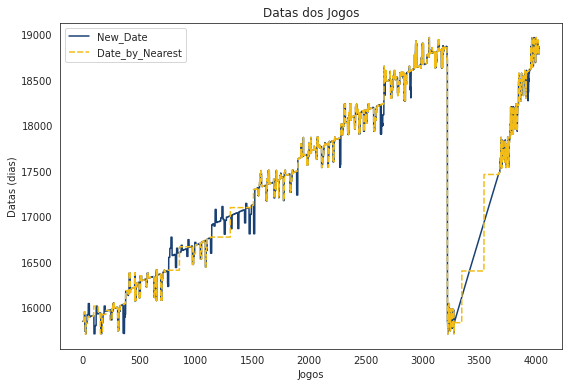

In [35]:
aux_df = df.copy()
aux_df['Date_by_Nearest'] = matplotlib.dates.date2num(pd.to_datetime(aux_df['Date_by_Nearest']))
aux_df['New_Date'] = matplotlib.dates.date2num(pd.to_datetime(aux_df['New_Date']))

plt.figure(figsize=(9,6))
sns.lineplot(data = aux_df[['New_Date','Date_by_Nearest']],
             palette = [colors['azul'],colors['amarelo']])

plt.title("Datas dos Jogos")
plt.xlabel("Jogos")
plt.ylabel("Datas (dias)")
plt.show()

### Integração (ou validação) dos Dados

Essa etapa é melhor descrita como validação dos dados, uma vez que nossos dados vem de fonte única, podemos testar a confiabilidade dos mesmos utilizando fontes externas e, por ser uma atividade simples, de forma manual. Desse modo, uma forma de analisar a coerência (e com isso a confiabilidade) dos dados se dá pela análise da classificação final do campeonato. Isso é, se a classificação final dos jogos com os dados coletados coincide com a classificação final do campeonato, os dados devem estar corretos, pois a probabilidade de ocorrerem dois ou mais erros, um anulando o outro, é muito baixa.

Para isso, tomamos a classificação final do campeonato:

In [36]:
year = 6 # 2013 = 0, 2014 = 1, etc
br = df.loc[380 * year:379 + 380 * year, ['Team 1', 'Team 2', 'Result']]
table = classification(br)
table

,points,games,wins,draws,defeats,goals for,goals against,goal difference
Flamengo / RJ,90,38,28,6,4,86,37,49
Santos / SP,74,38,22,8,8,60,33,27
Palmeiras / SP,74,38,21,11,6,61,32,29
Grêmio / RS,65,38,19,8,11,64,39,25
Athlético / PR,64,38,18,10,10,51,32,19
São Paulo / SP,63,38,17,12,9,39,30,9
Internacional / RS,57,38,16,9,13,44,39,5
Corinthians / SP,56,38,14,14,10,42,34,8
Fortaleza / CE,53,38,15,8,15,50,49,1
Goiás / GO,52,38,15,7,16,46,64,-18


Tendo passado por todas as classificações finais e vendo que as mesmas coincidiam com a classificação final do campeonato (basta buscar por Brasileirão no Google) podemos concluir que os resultados dos jogos estão corretos.

### Exploração dos Dados

Tendo finalizado a preparação dos dados, podemos explorar os mesmo. Dessa forma, vendo apenas pelos resultados das partidas, temos o seguinte cenário para a Série A:

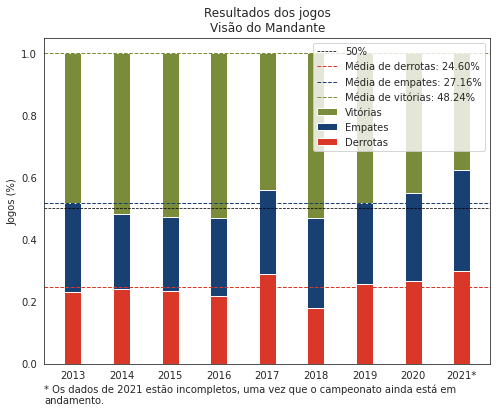

In [37]:
labels = []
wins = []
draws = []
losses = []
width = 0.35
fig, ax = plt.subplots(figsize = (8, 6))
for i in range(9):
    year = 2013 + i
    labels.append(str(year))
    gols_casa = np.array([int(df.loc[i, 'Result'][0]) for i in range(len(df)) 
                          if df.loc[i, 'Year'] == year and 
                          df.loc[i, 'Competition'] == 'Serie A'])
    
    gols_fora = np.array([int(df.loc[i, 'Result'][4]) for i in range(len(df))
                          if df.loc[i, 'Year'] == year and
                          df.loc[i, 'Competition'] == 'Serie A'])
    
    n = len(gols_casa)
    wins.append(np.sum(gols_casa > gols_fora) / n)
    draws.append(np.sum(gols_casa == gols_fora) / n)
    losses.append(np.sum(gols_casa < gols_fora) / n)

wins = np.array(wins)
draws = np.array(draws)
losses = np.array(losses)
labels[-1] = '2021*'

mean_losses = losses.mean()
mean_draws = draws.mean()
mean_wins = wins.mean()

ax.bar(labels, wins + draws + losses, width, label = 'Vitórias', color = colors['verde'])
ax.bar(labels, draws + losses, width, label = 'Empates', color = colors['azul'])
ax.bar(labels, losses, width, label = 'Derrotas', color = colors['vermelho'])
plt.axhline(0.5, ls = '--', lw = 0.75, c = 'black', label = '50%')
plt.axhline(mean_losses,
            ls = '--',
            lw = 1,
            c = colors['vermelho'],
            label = f'Média de derrotas: {100*mean_losses:.2f}%')
plt.axhline(mean_draws + mean_losses,
            ls = '--',
            lw = 1,
            c = colors['azul'],
            label = f'Média de empates: {100*mean_draws:.2f}%')
plt.axhline(mean_draws + mean_losses + mean_wins,
            ls = '--',
            lw = 1,
            c = colors['verde'],
            label = f'Média de vitórias: {100*mean_wins:.2f}%')
ax.set_ylabel('Jogos (%)')
ax.set_title('Resultados dos jogos\nVisão do Mandante')
ax.legend(loc = 'upper right')
plt.annotate('* Os dados de 2021 estão incompletos, uma vez que o campeonato ainda está em\nandamento.',
             (0,0),
             (0, -20),
             xycoords = 'axes fraction',
             textcoords = 'offset points',
             va = 'top')

plt.show()

Outra análise interessante se dá pelo saldo de gols de cada equipe após o término do campeonato:

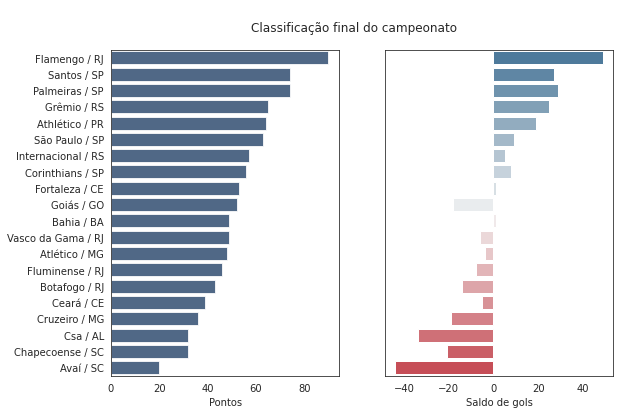

In [38]:
fig, axs = plt.subplots(1, 2, figsize = (9, 6), sharey = True)
sns.barplot(ax = axs[0], x = 'points', y = table.index, data = table, color = colors['azul'], alpha = 0.8)
sns.barplot(ax = axs[1], x = 'goal difference', y = table.index, data = table,
            palette = sns.diverging_palette(240, 10, n = 20))
fig.suptitle('\nClassificação final do campeonato')
axs[0].set_xlabel('Pontos')
axs[1].set_xlabel('Saldo de gols')
plt.show()

Outra análise de grande relevância se dá pela quantidade de gols por partida, bem como pelo mandante e pelo visitante, uma vez que, em nossa modelagem, podemos buscar como objetivo o placar como forma de determinar que time é o provável vencedor de um confronto. Dessa forma, saber a distribuição dos gols é relevante, uma vez que o modelo proposto deverá retornar resultados cujas distribuições condizem com a distribuição real. Dito isso, vamos calcular os gols em cada ano.

In [39]:
goals = [[] for j in range(10)]
h_goals = [[] for j in range(10)]
a_goals = [[] for j in range(10)]
for i in range(sa_end + 1):
    year = df.loc[i, 'Year']
    result = df.loc[i, 'Result']
    home = int(result[0])
    away = int(result[4])
    
    # atualizando os gols de cada ano
    goals[year - 2013].append(home + away)
    h_goals[year - 2013].append(home)
    a_goals[year - 2013].append(away)
    
    # atualizando para todos os anos
    goals[-1].append(home + away)
    h_goals[-1].append(home)
    a_goals[-1].append(away)

Agora, vamos plotar a distribuição dos gols:

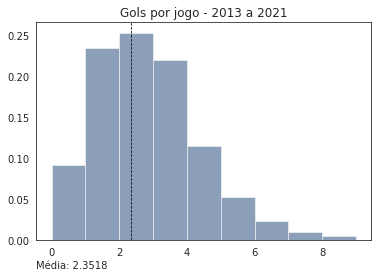

In [40]:
opt = 'All' # escolher entre ['All', 'Home', 'Away'],
year =  'All' # escolher entre 'All' ou algum ano de 2013 a 2021
plot_goals(opt, year, goals, h_goals, a_goals, colors)

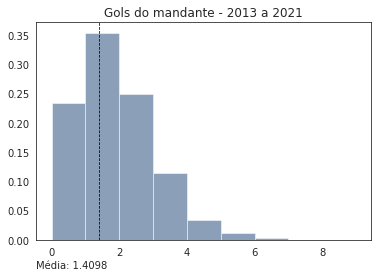

In [41]:
opt = 'Home' # escolher entre ['All', 'Home', 'Away'],
year =  'All' # escolher entre 'All' ou algum ano de 2013 a 2021
plot_goals(opt, year, goals, h_goals, a_goals, colors)

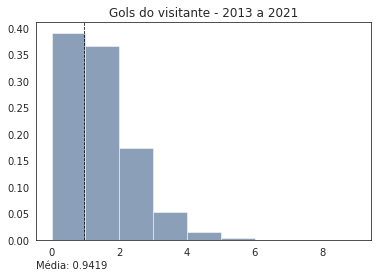

In [42]:
opt = 'Away' # escolher entre ['All', 'Home', 'Away'],
year =  'All' # escolher entre 'All' ou algum ano de 2013 a 2021
plot_goals(opt, year, goals, h_goals, a_goals, colors)

Dessa forma, como conclusão da Exploração dos Dados, podemos dizer que as seguintes assumptions são razoáveis para nosso modelo:

- a distribuição de gols por partida, bem como gols do mandante e do visitante, é uma Poisson e;

- existe uma força ofensiva e/ou defensiva maior para o mandante.

Note que essas assumptions fazem sentido, pois ao utilizá-las podemos ver que faz sentido o time mandante fazer mais gols enquanto sofre menos e, com isso, ter resultados mais positivos.

# Modelagem

### Seleção das técnicas de modelagem:

Alguns modelos que podem ser propostos, em nosso caso, são:

+ modelo naive, onde cada resultado apresenta probabilidade igual $\left(\frac{1}{3}\right)$;
+ modelo seminaive, onde levamos em consideração a proporção de resultados, assim, se 50% dos jogos acabaram com vitória do mandante, o mandante terá 50% de probabilidade de ganhar cada jogo (independentemente dos clubes);
+ modelo observador, agora considerando os clubes, ou seja, vendo o restropecto de cada clube em casa e fora, de modo a calcular a probabilidade de cada resultado por meio dessas observações;
+ modelo de Poisson simples sem mando de campo, onde cada time tem sua quantidade de gols extraída de uma Poisson de média igual a metade da média de gols por partida, dessa forma a quantidade de gols dessa partida tem distribuição de Poisson igual a média de gols por partida;
+ modelo de Poisson simples com mando de campo, onde em cada jogo o mandante tem sua quantidade de gols extraída de uma Poisson de média igual a média de gols por mandante, enquanto o visitante tem sua média igual a média de gols do visitante;
+ modelo de Poisson robusto, onde cada clube terá forças de ataque e de defesa, de modo que a quantidade de gols de cada clube será dada por uma Poisson de média igual a razão das duas forças $\left(\frac{ataque}{defesa}\right)$;
+ outro modelo de Poisson robusto, onde cada clube terá forças de ataque e de defesa considerando o mando de campo. A dinâmica é parecida com a acima, mas as médias das Poisson's serão $\left(\frac{ataque_{00}}{defesa_{11}}\right)$ e $\left(\frac{ataque_{11}}{defesa_{00}}\right)$, onde o primeiro $0$ no índice representa o mandante, o primeiro $1$ representa o visitante, o segundo $0$ representa a força me casa e o segundo $1$ a força fora;
+ um último modelo de Poisson, usando a ideia de jogo em casa e fora, além de utilizar uma função de esquecimento que fará com que resultados recentes tenham mais impacto no time que os resultados passados (pois para um jogo da vigésima rodada, uma vitória na décima nona deve ser mais influente que uma vitória na décima rodada); 
+ um modelo usando Cadeias de Markov. <span style = 'color:red'> **(A implementar)** </span>

### Gerando o design de teste:

Nosso teste será dado por meio de um treinamento incial com os dos dados até a décima nona rodada (final do primeiro turno). Feito isso, vamos rodar o modelo para predizer o campeonato rodada a rodada, até o fim do campeonato, buscando as probabilidades de cada time ser campeão. Essa abordagem se dará por meio de simulações, onde cada jogo será simulado uma grande quantidade de vezes, o que, pela Lei dos Grandes Números, diz que a distribuição dessas simulações é similar a distribuição real. Após a execução dessa simulação, utilizando apenas os dados do primeiro turno, vamos incluir os 10 jogos da vigésima rodada e fazer esse processo novamente, fazendo isso, rodada a rodada, até o final do campeonato. Dessa forma, podemos ter um acompanhamento das probabilidades de cada time ser campeão, ir para a libertadores, sul-americana ou ser rebaixado em todo o segundo turno.

Ao final, podemos ver qual modelo obteve melhores predições.

### Construindo os modelos:

Primeiramente, note que os três primeiros modelos buscam predizer **resultados**, enquanto os três seguintes buscam predizer **placares**. Para evitar maiores problemas com a modelagem e testes, vamos atribuir os placares de 1 x 0, 0 x 0 ou 0 x 1 nos três primeiros modelos, mas para efeitos comparativos, utilizar apenas as predições para a classificação final do campeonato.

Dito isso, vamos iniciar a construção dos modelos.

Elaborados os modelos que predizem resultado (vitórias, derrotas ou empates), vamos a elaboração dos que predizem resultados.

Uma coisa interessante a se comentar é que as funções para os três últimos modelos de Poisson é a mesma, o que vai diferenciá-los é o treinamento dos parâmetros, os quais serão um pouco mais custosos em comparação aos treinamentos dos demais modelos, pois esses envolvem a minimização de funções. Pensando nessa complexidade, podemos optar por desconsiderar os dados da Série B do Campeonato Brasileiro, uma vez que o nível é um pouco inferior, além de dobrar o número de parâmetros a serem estimados, o que aumenta, e muito a complexidade do modelo.

In [43]:
df = df[:sa_end + 1] # excluindo os dados da Série B

Para finalizar os modelos, devemos elaborar funções para treinar os devidos modelos.

Apesar do Modelo Ingênuo não precisar de treino (a probabilidade é fixa), vamos elaborar uma função de treino para ele. Isso irá nos facilitar mais adiante.

Agora temos as funções que treinam os modelos mais simples, isso é, que são funções ou distribuições que dependem exclusivamente de estatísticas simples dos dados.

Para o treinamento dos modelos de Poisson mais trabalhados, onde cada clube tem uma força de ataque e uma força de defesa, devemos pensar em termos de probabilidades, isso é, devemos encontrar parâmetros que, dadas as observações do treino, maximizam a verossimilhança das observações. Ou seja, vamos buscar esses parâmetros por meio da maximização da função de verossimilhança. Para modelar isso, defina:

+ $\theta_{time}$ o vetor de força de ataque de um time, assim $\theta_{time_0}$ é a força de ataque em casa e $\theta_{time_1}$ é a força de ataque fora;
+ $\omega_{time}$ o vetor de força de defesa de um time, assim $\omega_{time_0}$ é a força de defesa em casa e $\omega_{time_1}$ é a força de defesa fora;
+ $\lambda_{time} = [\theta_{time}, \omega_{time}]$ são os parâmetros de cada time, enquanto $\Lambda$ é conjunto de todos os $\lambda_{time}$;
+ $L(jogos | \Lambda)$ é a função de verossimilhança de um conjunto de jogos dados um vetor de parâmetros.

Para explicar o por que de buscar pela máxima verossimilhança, vamos analisar brevemente essas equações. Primeiro que são dados probabilisticos, logo, faz sentido trabalhar com verossimilhança. Em segundo lugar, como cada conjunto de jogos é dado por um conjunto fechado de rodadas, cada conjunto de jogos terá um múltiplo de $10$ jogos. Além disso, como estamos avaliando apenas dentro de um ano, no máximo, $370$ jogos ($380$ após a última rodada, mas nesse caso não ajuda, pois o campeonato já acabou, logo não tem o que ser predito), temos, no máximo, $370$ equações para realizar o fitting, mas temos $20\cdot 4 = 80$ variáveis (no modelo em que consideramos a mesma força para cada time, independentemente do mando do jogo, esse número diminui para $40$, pois podemos considerar a força em casa como igual a força fora), ou seja, temos muito mais equações que variáveis, as quais muitas vezes, se fôssemos resolver por sistema linear, levariam a um sistema impossível (como num exemplo em que o time A ganha do time B, que ganha do C e que, por sua vez, ganha do A).

Explicada a função de verossimilhança, queremos encontrar os parâmetros que maximizem
\begin{align}
L(jogos | \Lambda) & = P(resultado ~ do ~ jogo ~ 1 | \Lambda)\cdot P(resultado ~ do ~ jogo ~ 2 | \Lambda)\cdot \dots\cdot  P(resultado ~ do ~ jogo ~ n | \Lambda) \\
& = P(gols ~ do ~ mandante ~ do ~ jogo ~ 1 | \Lambda)\cdot P(gols ~ do ~ visitante ~ do ~ jogo ~ 1 | \Lambda)\cdot \dots\cdot P(gols ~ do ~ mandante ~ do ~ jogo ~ n | \Lambda)\cdot P(gols ~ do ~ visitante ~ do ~ jogo ~ n | \Lambda)
\end{align}

onde cada variável dessas segue uma Poisson, ou seja, são fáceis de calcular. Mas agora temos problemas numéricos, isso é, essa expressão representa um produto de diversos números do intervalo $(0, 1)$, logo isso resulta em um número muito pequeno. Para evitar esses erros, podemos tirar o log dessa expressão, o que também transforma todos os produtos em somas. Por fim, mais questão de otimização, vamos multiplicar essa expressão por $-1$, o que transforma isso em um problema de minimização da expressão
\begin{align}
-\ln{L(jogos | \Lambda)} & = - \ln{P(gols ~ do ~ mandante ~ do ~ jogo ~ 1 | \Lambda)} - \ln{P(gols ~ do ~ visitante ~ do ~ jogo ~ 1 | \Lambda)} - \dots - \ln{P(gols ~ do ~ mandante ~ do ~ jogo ~ n | \Lambda)} \\ & ~ ~ ~ ~ - \ln{P(gols ~ do ~ visitante ~ do ~ jogo ~ n | \Lambda)}.
\end{align}

Outra coisa que devemos comentar é que o mínimo não é único, ou seja, se $\Lambda$ é um conjunto de parâmetros que minimiza a verossimilhança, então $\alpha\Lambda, \forall \alpha \in \mathbb{R}^*$ também é, pois de $\Lambda$ temos Poisson's de média $\frac{\theta_{time_i}}{\omega_{time_i}}$, enquanto de $\alpha\Lambda$ temos as Poisson's de média $\frac{\alpha\theta_{time_i}}{\alpha\omega_{time_i}} = \frac{\theta_{time_i}}{\omega_{time_i}}$, ou seja, multiplicar o vetor $\Lambda$ por uma constante real mantém a propriedade minimizadora. Dessa forma, vamos fixar a primeira entrada de $\Lambda$ como $1$.

Além disso, apesar de que mesmo que se todas as entradas de $\Lambda$ forem negativas a modelagem funcione, temos que não faz sentido tomá-las negativas, pois suas entradas (as forças ofensivas e defensivas), podem ser interpretadas como uma medida de quantos gols um determinado time tende a fazer e/ou tomar. Com isso, incluimos outra restrição, a de que as entradas de $\Lambda$ estejam em $\mathbb{R}_{> 0}$.

Por fim, o treinamento do modelo de Poisson com esquecimento deve, primeiramente, ter uma função de esquecimento. Feito isso, o processo será similar ao descrito acima, exceto pela inclusão de um termo multiplicador dentro dos logarítmos, o qual é função do tempo decorrido desde cada partida. A função de esquecimento tem a seguinte cara:

$f(t) = \dfrac{k}{c\cdot \log{t} + k}$, com $c$ e $k$ constantes.

Dito isso, vamos implementar a função de esquecimento e as funções de verossimilhança para, em seguida, implementar a função de treino, que visa encontrar o $\Lambda$ que minimiza essa função.

Tendo a função de esquecimento e as funções de verossimilhança, podemos implementar as funções que farão o fitting do modelo.

Note que todas as funções de treino recebem um argumento *args. Isso visa uma facilidade na hora de implementar o loop para testar ano a ano, que vamos elaborar agora.

In [44]:
# def run_models(model, training, years, rounds, games, *args):
#     '''
#     Treina e executa os modelos dados para os anos e
#     rodadas dadas.
#     '''
#     results = {}
#     if type(model) == list:
#         for i in range(len(model)):
#             results[model[i]] = run_models(model[i], training[i], years, rounds, games, args)
            
#         return results
    
#     if model == forgetting_poisson:
#         with_date = True
#     else:
#         with_date = False
    
#     for year in years:
#         i_year = year - 2013
#         for rd in rounds:
#             if rd == rounds[0]:
#                 x0 = None
#             elif args != ():
                

In [45]:
# models = [forgetting_poisson]
# for model in models:
#     if model == forgetting_poisson:
#         print('ok')

In [46]:
# run_models(naive_model, train_naive_model, [2020], [i for i in range(19, 38)], df)

Agora vamos fitar o modelo para o primeiro turno de 2020.

In [47]:
games = df[7 * 380 : 7 * 380 + 190]
aux = df.loc[7 * 380 + 190 : 7 * 380 + 200, 'New_Date']
date = matplotlib.dates.date2num(pd.to_datetime(aux)).mean()
times = []

t = tm.time()
seminaive = train_naive_model()
tf = tm.time()
times.append(tf - t)

t = tm.time()
seminaive = train_seminaive_model(games)
tf = tm.time()
times.append(tf - t)

t = tm.time()
observer = train_observer_model(games)
tf = tm.time()
times.append(tf - t)

t = tm.time()
simple_poisson = train_simple_poisson_neutral(games)
tf = tm.time()
times.append(tf - t)

t = tm.time()
simple_poisson_non_neutral = train_simple_poisson_non_neutral(games)
tf = tm.time()
times.append(tf - t)

t = tm.time()
poisson_two_par = train_simple_poisson(games)
tf = tm.time()
times.append(tf - t)

t = tm.time()
poisson_four_par = train_complex_poisson(games)
tf = tm.time()
times.append(tf - t)

t = tm.time()
forgetting_poisson, k, c = train_forgetting_poisson(games, date = date)
tf = tm.time()
times.append(tf - t)

print(f'Modelo ingênuo treinado em {times[0]:.4f} segundos.')
print(f'Modelo semi-ingênuo treinado em {times[1]:.4f} segundos.')
print(f'Modelo observador treinado em {times[2]:.4f} segundos.')
print(f'Modelo de Poisson simples sem mando de campo treinado em {times[3]:.4f} segundos.')
print(f'Modelo de Poisson simples com mando de campo treinado em {times[4]:.4f} segundos.')
print(f'Modelo de Poisson com forças e sem mando de campo treinado em {times[5]:.4f} segundos.')
print(f'Modelo de Poisson com forças e com mando de campo treinado em {times[6]:.4f} segundos.')
print(f'Modelo de Poisson com forças, mando de campo e esquecimento treinado em {times[7]:.4f} segundos.')

/home/igor/Área de Trabalho/FGV/06 - 6º Semestre/06 - AMD/web-scraping/models.py:232: RuntimeWarning: divide by zero encountered in double_scalars
  mu = forces[home]['Ataque'] / forces[away]['Defesa']
/home/igor/Área de Trabalho/FGV/06 - 6º Semestre/06 - AMD/web-scraping/models.py:235: RuntimeWarning: divide by zero encountered in double_scalars
  mu = forces[away]['Ataque'] / forces[home]['Defesa']
/home/igor/.local/lib/python3.8/site-packages/scipy/stats/_discrete_distns.py:818: RuntimeWarning: invalid value encountered in subtract
  Pk = special.xlogy(k, mu) - gamln(k + 1) - mu
/home/igor/Área de Trabalho/FGV/06 - 6º Semestre/06 - AMD/web-scraping/models.py:235: RuntimeWarning: invalid value encountered in double_scalars
  mu = forces[away]['Ataque'] / forces[home]['Defesa']
/home/igor/Área de Trabalho/FGV/06 - 6º Semestre/06 - AMD/web-scraping/models.py:232: RuntimeWarning: invalid value encountered in double_scalars
  mu = forces[home]['Ataque'] / forces[away]['Defesa']
/home/igo

Modelo ingênuo treinado em 0.0001 segundos.
Modelo semi-ingênuo treinado em 0.0022 segundos.
Modelo observador treinado em 0.0072 segundos.
Modelo de Poisson simples sem mando de campo treinado em 0.0022 segundos.
Modelo de Poisson simples com mando de campo treinado em 0.0018 segundos.
Modelo de Poisson com forças e sem mando de campo treinado em 46.6872 segundos.
Modelo de Poisson com forças e com mando de campo treinado em 86.0797 segundos.
Modelo de Poisson com forças, mando de campo e esquecimento treinado em 39.4839 segundos.


### Validação do modelo:

## V. Evaluation                    

+ Evaluate results: 
+ Review process: 
+ Determine next steps: 

## VI. Deployment

+ Plan deployment: 
+ Plan monitoring and maintenance: 
+ Produce final report: 
+ Review project: 